# Probabilistic Relational Model - IMbalanced Learning

In [70]:
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import Subset, ConcatDataset
import torchmetrics
import torchvision

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from torchvision import datasets, transforms
from tqdm.autonotebook import tqdm

Modelo

In [72]:
from torchvision.models import resnet50

mean_losses = []
mean_acc = []
mean_f1s = []

class ResNet50F(pl.LightningModule):
    def __init__(self,class_sizes=[1,1]):
        super().__init__()
        self.n_classes = len(class_sizes)
        
        # metrics
        task = "multiclass" if self.n_classes > 2 else "binary"
        self.accuracy = torchmetrics.Accuracy(task=task, num_classes=self.n_classes)
        self.f1score = torchmetrics.F1Score(task=task, num_classes=self.n_classes)
        
        self.model = resnet50(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, self.n_classes, bias=True)
            
        self.loss = nn.CrossEntropyLoss().cuda()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_no):
        x, y = batch
        logits = self(x)
        
        y_onehot = F.one_hot(y, num_classes=self.n_classes).long()
        acc = self.accuracy(logits, y_onehot)
        f1s = self.f1score(logits, y_onehot)
        mean_acc.append(acc.item())
        mean_f1s.append(f1s.item())
        
        mean_loss = self.loss(logits, y)
        mean_losses.append(mean_loss)
        
        return mean_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=1e-4)
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.OneCycleLR(
                                optimizer ,max_lr=0.01,
                                steps_per_epoch=len(trainloader),
                                epochs=EPOCHS)
        }

Construir subsets a partir de los indices de clase

In [64]:
data_transforms = transforms.Compose([
    transforms.RandomSizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder('../data/PlantVillage/train', data_transforms)
print(len(train_dataset), train_dataset.class_to_idx)
val_dataset = datasets.ImageFolder('../data/PlantVillage/val', data_transforms)
print(len(val_dataset), val_dataset.class_to_idx)

/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/torchvision/transforms/transforms.py:703: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


1598 {'tomato_healthy': 0, 'tomato_infected': 1}
366 {'tomato_healthy': 0, 'tomato_infected': 1}


In [65]:
class_0_idxs = torch.nonzero(torch.Tensor(train_dataset.targets)==0).flatten()
class_1_idxs = torch.nonzero(torch.Tensor(train_dataset.targets)==1).flatten()
# Provocar bias cogiendo un porcentaje de la clase 1 solamente (modificando el porcentaje hasta obtener b_deg deseado)
# class_1_idxs = class_1_idxs[torch.randperm(len(class_1_idxs))[:int(len(class_1_idxs)*.209)]]

c0_s, c1_s = len(class_0_idxs), len(class_1_idxs)
b_deg = c0_s / c1_s
print('Class 0:', len(class_0_idxs), '/ Class 1:', len(class_1_idxs), '/ BDeg: ', b_deg)

class_1_subset = Subset(train_dataset, class_1_idxs)

# Lista de DataSets que luego se envolveran en DataLoaders
train_subsets = []
for i in range(int(np.ceil(b_deg))):
    class_0_subset = Subset(train_dataset, class_0_idxs[i*c1_s : i*c1_s+c1_s])
    train_subsets.append(ConcatDataset([class_0_subset, class_1_subset]))

for p in train_subsets:
    print(len(p), len(p)-c1_s)

Class 0: 1301 / Class 1: 297 / BDeg:  4.380471380471381
594 297
594 297
594 297
594 297
410 113


Bucle de entrenamiento

In [73]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    model.unfreeze()
    return predicted_class, probabilities

EPOCHS=15
BATCH_SIZE=10

testloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = ResNet50F()

for stage, train_subset in enumerate(train_subsets):
    print(f'------------stage nº {stage}----------------------')
    
    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    
    # Training
    trainer = pl.Trainer(gpus=1, max_epochs=EPOCHS, devices=1, accelerator="gpu")
    trainer.fit(model, trainloader)
    
    # Testing
    true_y, pred_y = [], []
    for batch in tqdm(iter(testloader), total=len(testloader)):
        x, y = batch
        true_y.extend(y)
        preds, probs = get_prediction(x, model)
        pred_y.extend(preds.cpu())

print(classification_report(true_y, pred_y, digits=3))

/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


------------fold nº 0----------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | accuracy | BinaryAccuracy   | 0     
1 | f1score  | BinaryF1Score    | 0     
2 | model    | ResNet           | 23.5 M
3 | loss     | CrossEntropyLoss | 0     
----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


  0%|          | 0/37 [00:00<?, ?it/s]

/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


------------fold nº 1----------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | accuracy | BinaryAccuracy   | 0     
1 | f1score  | BinaryF1Score    | 0     
2 | model    | ResNet           | 23.5 M
3 | loss     | CrossEntropyLoss | 0     
----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


  0%|          | 0/37 [00:00<?, ?it/s]

/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


------------fold nº 2----------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | accuracy | BinaryAccuracy   | 0     
1 | f1score  | BinaryF1Score    | 0     
2 | model    | ResNet           | 23.5 M
3 | loss     | CrossEntropyLoss | 0     
----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


  0%|          | 0/37 [00:00<?, ?it/s]

/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


------------fold nº 3----------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | accuracy | BinaryAccuracy   | 0     
1 | f1score  | BinaryF1Score    | 0     
2 | model    | ResNet           | 23.5 M
3 | loss     | CrossEntropyLoss | 0     
----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


  0%|          | 0/37 [00:00<?, ?it/s]

/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: UserWarning: The flag `devices=1` will be ignored, instead the device specific number 1 will be used
  f"The flag `devices={devices}` will be ignored, "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


------------fold nº 4----------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | accuracy | BinaryAccuracy   | 0     
1 | f1score  | BinaryF1Score    | 0     
2 | model    | ResNet           | 23.5 M
3 | loss     | CrossEntropyLoss | 0     
----------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/d/miniconda3/envs/tfg/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1559: PossibleU

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


  0%|          | 0/37 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0      1.000     0.972     0.986       290
           1      0.905     1.000     0.950        76

    accuracy                          0.978       366
   macro avg      0.952     0.986     0.968       366
weighted avg      0.980     0.978     0.979       366



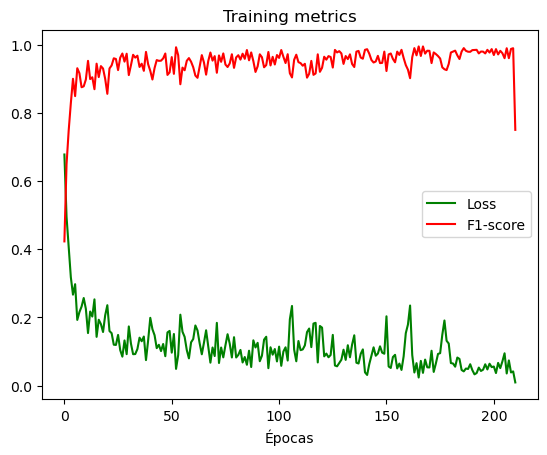

In [75]:
# Plot mean loss
x_axis = [i for i in range(211)]

splits=20
plt.plot(x_axis, [sum(mean_losses[i:i + splits])/splits for i in range(0, len(mean_losses), splits)], 'g', label='Loss')
# plt.plot(x_axis, [sum(mean_acc[i:i + splits])/splits for i in range(0, len(mean_acc), splits)], 'b', label='Accuracy')
plt.plot(x_axis, [sum(mean_f1s[i:i + splits])/splits for i in range(0, len(mean_f1s), splits)], 'r', label='F1-score')
plt.title('Training metrics')
plt.xlabel('Épocas')
# plt.ylabel('Loss media')
plt.legend()
plt.show()